In [ ]:
pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.2/118.2 kB 11.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import sktime
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Data/power

/content/drive/MyDrive/Data/power


In [ ]:
train = pd.read_csv("pre_train.csv", index_col = 0)
test = pd.read_csv("pre_test.csv", index_col = 0)
train

,building_number,temperature,windspeed,humidity,power_consumption,day,month,day_of_week,cos_time,sin_time,...,hour_mean,hour_std,discomfort,CDH,sensory_temperature,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity
0,1,18.6,0.9,42.0,1085.28,1,6,2,1.000000,0.000000,...,1706.318118,446.882767,63.09388,-7.4,20.751584,Other Buildings,110634.00,39570.00,0.0,0.0
1,1,18.0,1.1,45.0,1047.36,1,6,2,0.965926,0.258819,...,1622.620235,439.662704,62.46400,-15.4,20.008954,Other Buildings,110634.00,39570.00,0.0,0.0
2,1,17.7,1.5,45.0,974.88,1,6,2,0.866025,0.500000,...,1506.971294,412.071906,62.08735,-23.7,19.476910,Other Buildings,110634.00,39570.00,0.0,0.0
3,1,16.7,1.4,48.0,953.76,1,6,2,0.707107,0.707107,...,1437.365647,391.205981,60.89884,-33.0,18.487958,Other Buildings,110634.00,39570.00,0.0,0.0
4,1,18.4,2.8,43.0,986.40,1,6,2,0.500000,0.866025,...,1447.321412,381.099697,62.88788,-40.6,19.751534,Other Buildings,110634.00,39570.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,0.9,86.0,881.04,24,8,2,0.258819,-0.965926,...,1010.462118,161.399578,72.38034,-19.6,25.302757,Hotel and Resort,57497.84,40035.23,0.0,0.0
203996,100,22.4,1.3,86.0,798.96,24,8,2,0.500000,-0.866025,...,928.125176,137.566008,71.21736,-20.2,24.446518,Hotel and Resort,57497.84,40035.23,0.0,0.0
203997,100,21.3,1.0,92.0,825.12,24,8,2,0.707107,-0.707107,...,830.032941,128.300189,69.79704,-22.3,23.433400,Hotel and Resort,57497.84,40035.23,0.0,0.0
203998,100,21.0,0.3,94.0,640.08,24,8,2,0.866025,-0.500000,...,723.100235,112.464079,69.41060,-25.1,23.661275,Hotel and Resort,57497.84,40035.23,0.0,0.0


# 테스트 1
---

In [ ]:
train_1 = train
test_1 = test

# 카테고리 컬럼 설정
train_1[['building_type']] = train_1[[ 'building_type']].astype('category')
test_1[['building_type']] = test_1[['building_type']].astype('category')

train_1 = pd.get_dummies(train_1, columns = ['building_type'])

# 특성과 라벨 분리
X_train_1 = train_1.drop(columns = ['power_consumption'])
y_train_1 = train_1['power_consumption']



In [ ]:
# 데이터 정규화
scaler = StandardScaler()
X_train_scaled_1 = scaler.fit_transform(X_train_1)

# 데이터 분할
X_train_split_1, X_test_1, y_train_split_1, y_test_1 = train_test_split(X_train_scaled_1, y_train_1, random_state=42)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [5000],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
}

# XGBoost 모델 생성
xgb_model_1 = XGBRegressor(objective='reg:squarederror', random_state=42)

def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

xgb_model_1.fit(X_train_1, y_train_1)

y_pred_1 = xgb_model_1.predict(X_test_1)
print(f"Test #1: {smape(y_test_1, y_pred_1)}")

Test #1: 106.27355878162138


# 테스트 2
---
건물별로 모델링 해보기

In [ ]:
train_2 = train

# 카테고리 컬럼 설정
train_2[['building_type']] = train_2[[ 'building_type']].astype('category')

train_2 = pd.get_dummies(train_2, columns = ['building_type'])

# 특성과 라벨 분리
y = train_2.loc[train['building_number'] == 1, 'power_consumption']
x = train_2.loc[train['building_number'] == 1].drop(columns = 'power_consumption')

In [ ]:
x.columns

Index(['building_number', 'temperature', 'windspeed', 'humidity', 'day',
       'month', 'day_of_week', 'cos_time', 'sin_time', 'holiday',
       'day_hour_mean', 'hour_mean', 'hour_std', 'discomfort', 'CDH',
       'total_area', 'cooling_area', 'solar_power_capacity', 'ess_capacity',
       'building_type_Apartment', 'building_type_Commercial',
       'building_type_Data Center',
       'building_type_Department Store and Outlet',
       'building_type_Discount Mart', 'building_type_Hospital',
       'building_type_Hotel and Resort',
       'building_type_Knowledge Industry Center',
       'building_type_Other Buildings', 'building_type_Public',
       'building_type_Research Institute', 'building_type_University'],
      dtype='object')

In [ ]:
x

,building_number,temperature,windspeed,humidity,day,month,day_of_week,cos_time,sin_time,holiday,...,building_type_Data Center,building_type_Department Store and Outlet,building_type_Discount Mart,building_type_Hospital,building_type_Hotel and Resort,building_type_Knowledge Industry Center,building_type_Other Buildings,building_type_Public,building_type_Research Institute,building_type_University
0,1,18.6,0.9,42.0,1,6,2,1.000000,0.000000,False,...,0,0,0,0,0,0,1,0,0,0
1,1,18.0,1.1,45.0,1,6,2,0.965926,0.258819,False,...,0,0,0,0,0,0,1,0,0,0
2,1,17.7,1.5,45.0,1,6,2,0.866025,0.500000,False,...,0,0,0,0,0,0,1,0,0,0
3,1,16.7,1.4,48.0,1,6,2,0.707107,0.707107,False,...,0,0,0,0,0,0,1,0,0,0
4,1,18.4,2.8,43.0,1,6,2,0.500000,0.866025,False,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,1,25.5,2.9,63.0,24,8,2,0.258819,-0.965926,False,...,0,0,0,0,0,0,1,0,0,0
2036,1,25.0,2.6,66.0,24,8,2,0.500000,-0.866025,False,...,0,0,0,0,0,0,1,0,0,0
2037,1,24.6,1.3,67.0,24,8,2,0.707107,-0.707107,False,...,0,0,0,0,0,0,1,0,0,0
2038,1,24.1,2.1,70.0,24,8,2,0.866025,-0.500000,False,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
# 데이터 정규화
scaler = StandardScaler()
X_train_scaled_2 = scaler.fit_transform(x)

# 데이터 분할
# X_train_split_2, X_test_2, y_train_split_2, y_test_2 = train_test_split(X_train_scaled_2, y, random_state=42)
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)


# XGBoost 모델 생성
xgb_model_2 = XGBRegressor(n_estimators = 10000, eta = 0.01, min_child_weight = 6,
                       max_depth = 5, colsample_bytree = 0.8,
                       subsample = 0.9, seed=0)

def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

xgb_model_2.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_valid, y_valid)],
                early_stopping_rounds = 300, verbose = False)

pred = xgb_model_2.predict(x_valid)
print(f"[Test #2-1] SMAPE: {smape(y_valid, pred)}")

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[Test #2-1] SMAPE: 5.848202848220082


best iterations: 3106
SMAPE : 5.848202848220082


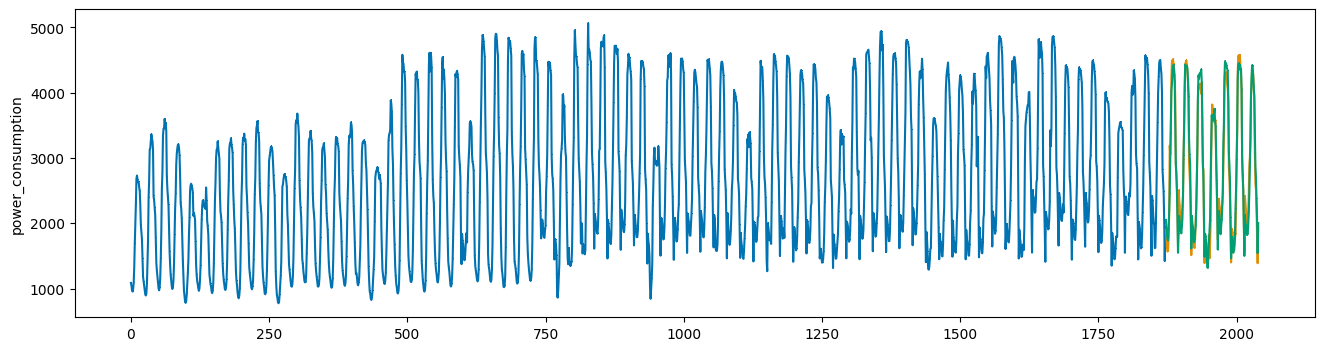

In [ ]:
# 주황색 : 실제 전력소비량, 초록색 : 예측값
pred = xgb_model_2.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_model_2.best_iteration))
print('SMAPE : {}'.format(smape(y_valid, pred)))

In [ ]:
feature_importance = pd.DataFrame(xgb_model_2.feature_importances_.reshape((1, -1)), columns=x_train.columns, index=['feature_importance'])
feature_importance

,building_number,temperature,windspeed,humidity,day,month,day_of_week,cos_time,sin_time,holiday,...,building_type_Data Center,building_type_Department Store and Outlet,building_type_Discount Mart,building_type_Hospital,building_type_Hotel and Resort,building_type_Knowledge Industry Center,building_type_Other Buildings,building_type_Public,building_type_Research Institute,building_type_University
feature_importance,0.0,0.003921,0.001377,0.005623,0.007511,0.113474,0.016203,0.007164,0.008619,0.040027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(+) 하이퍼파라미터 튜닝

In [ ]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from tqdm import tqdm

df = pd.DataFrame(columns = ['n_estimators', 'eta', 'min_child_weight','max_depth', 'colsample_bytree', 'subsample'])
preds = np.array([])

grid = {'n_estimators' : [100], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 8, 1),
        'max_depth' : np.arange(3,9,1) , 'colsample_bytree' :np.arange(0.8, 1.0, 0.1),
        'subsample' :np.arange(0.8, 1.0, 0.1)}

for i in tqdm(np.arange(1, 101)):
  train_2 = train
  train_2 = pd.get_dummies(train_2, columns = ['building_type'])
  y_2 = train_2.loc[train['building_number'] == i, 'power_consumption']
  x_2 = train_2.loc[train['building_number'] == i].drop(columns = 'power_consumption')
  y_train_2, y_test_2, x_train_2, x_test_2 = temporal_train_test_split(y = y_2, X = x_2, test_size = 168)

  pds = PredefinedSplit(np.append(-np.ones(len(x)-168), np.zeros(168)))
  gcv = GridSearchCV(estimator = XGBRegressor(seed = 0),
                       param_grid = grid, scoring = smape, cv = pds, refit = True, verbose = True)

  gcv.fit(x_train_2, y_train_2)
  best = gcv.best_estimator_
  params = gcv.best_params_
  print(params)
  pred_2 = best.predict(x_test_2)
  building = 'building'+str(i)
  print(building + '|| SMAPE : {}'.format(smape(y_test_2, pred_2)))
  preds_2 = np.append(preds_2, pred_2)
  df = pd.concat([df, pd.DataFrame(params, index = [0])], axis = 0)
  df.to_csv('./hyperparameter_xgb.csv', index = False)

  0%|          | 0/100 [00:00<?, ?it/s]

Fitting 1 folds for each of 168 candidates, totalling 168 fits


IndexError: ignored

In [ ]:
train_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   building_number       204000 non-null  int64   
 1   temperature           204000 non-null  float64 
 2   windspeed             203981 non-null  float64 
 3   humidity              203991 non-null  float64 
 4   power_consumption     204000 non-null  float64 
 5   day                   204000 non-null  int64   
 6   month                 204000 non-null  int64   
 7   day_of_week           204000 non-null  int64   
 8   cos_time              204000 non-null  float64 
 9   sin_time              204000 non-null  float64 
 10  holiday               204000 non-null  bool    
 11  day_hour_mean         204000 non-null  float64 
 12  hour_mean             204000 non-null  float64 
 13  hour_std              204000 non-null  float64 
 14  discomfort            203991 non-nul

# 테스트 3
---
* 커스텀 목적함수 사용

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[Test #3-1] SMAPE: 6.503618172061755
best iterations: 395
SMAPE : 6.503618172061755


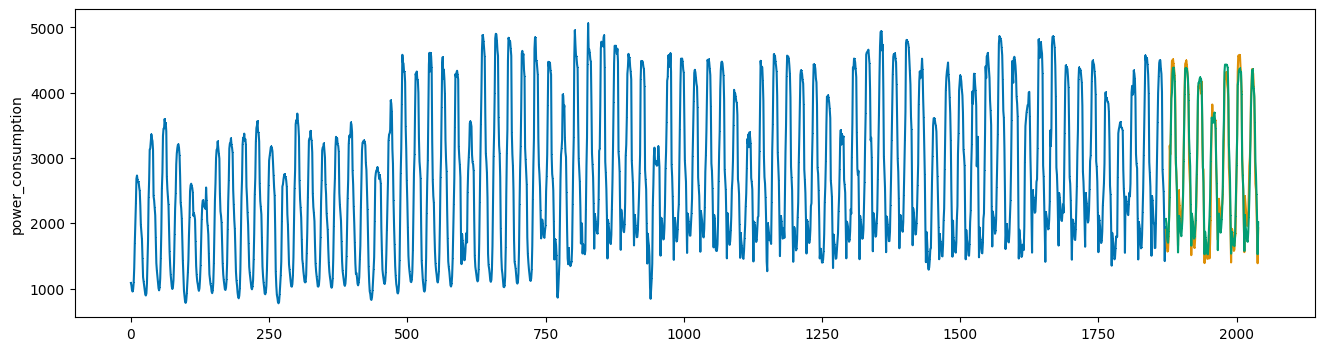

In [ ]:
train_3 = train

# 카테고리 컬럼 설정
train_3[['building_type']] = train_3[[ 'building_type']].astype('category')

train_3 = pd.get_dummies(train_3, columns = ['building_type'])

# 특성과 라벨 분리
y_3 = train_3.loc[train['building_number'] == 1, 'power_consumption']
x_3 = train_3.loc[train['building_number'] == 1].drop(columns = 'power_consumption')

# 커스텀 목적함수
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled_3 = scaler.fit_transform(x_3)

# 데이터 분할
y_train_3, y_valid_3, x_train_3, x_valid_3 = temporal_train_test_split(y = y_3, X = x_3, test_size = 168)


# XGBoost 모델 생성
xgb_model_3 = XGBRegressor(n_estimators = 10000, eta = 0.01, min_child_weight = 6,
                       max_depth = 5, colsample_bytree = 0.8,
                       subsample = 0.9, seed=0)

# 커스텀 목적함수 사용
xgb_model_3.set_params(**{'objective' : weighted_mse(100)})

# SAMPE 계산 함수
def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

xgb_model_3.fit(x_train_3, y_train_3, eval_set = [(x_train_3, y_train_3), (x_valid_3, y_valid_3)],
                early_stopping_rounds = 300, verbose = False)

pred_3 = xgb_model_3.predict(x_valid_3)
print(f"[Test #3-1] SMAPE: {smape(y_valid_3, pred_3)}")

# 주황색 : 실제 전력소비량, 초록생 : 예측값
pred_3 = xgb_model_3.predict(x_valid_3)
pred_3 = pd.Series(pred_3)
pred_3.index = np.arange(y_valid_3.index[0], y_valid_3.index[-1]+1)
plot_series(y_train_3, y_valid_3, pd.Series(pred_3), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_model_3.best_iteration))
print('SMAPE : {}'.format(smape(y_valid_3, pred_3)))

weighted MSE alpha tuning

In [ ]:
alpha_list = []
smape_list = []
for i in tqdm(range(100)):
    train_3 = train
    train_3 = pd.get_dummies(train_3, columns = ['building_type'])
    y = train_3.loc[train['building_number'] == i+1, 'power_consumption']
    x = train_3.loc[train['building_number'] == i+1].drop(columns = 'power_consumption')

    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)
    xgb = XGBRegressor(seed = 0,
                      n_estimators = 10000, eta = 0.01, min_child_weight = 6,
                       max_depth = 5, colsample_bytree = 0.8,
                       subsample = 0.9)

    xgb.fit(x_train, y_train)
    pred0 = xgb.predict(x_test)
    best_alpha = 0
    score0 = smape(y_test,pred0)

    for j in [1, 3, 5, 7, 10, 25, 50, 75, 100]:
        xgb = XGBRegressor(seed = 0,
                      n_estimators = 10000, eta = 0.01, min_child_weight = 6,
                       max_depth = 5, colsample_bytree = 0.8,
                       subsample = 0.9)
        xgb.set_params(**{'objective' : weighted_mse(j)})

        xgb.fit(x_train, y_train)
        pred1 = xgb.predict(x_test)
        score1 = smape(y_test, pred1)
        if score1 < score0:
            best_alpha = j
            score0 = score1

    alpha_list.append(best_alpha)
    smape_list.append(score0)
    print("building {} || best score : {} || alpha : {}".format(i+1, score0, best_alpha))

  0%|          | 0/100 [05:41<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

xtree = ExtraTreesClassifier(n_estimators=5, random_state=2)
xtree.fit(X_train, y_train)

# 테스트 4
---
temporal_train_test_split 사용해서 분할해보기

In [ ]:
train_4 = train
test_4 = test

# 카테고리 컬럼 설정
train_4[['building_type']] = train_4[[ 'building_type']].astype('category')

train_4 = pd.get_dummies(train_4, columns = ['building_type'])

# 특성과 라벨 분리
X_train_4 = train_4.drop(columns = ['power_consumption'])
y_train_4 = train_4['power_consumption']

In [ ]:
# 데이터 정규화
scaler = StandardScaler()
X_train_scaled_4 = scaler.fit_transform(X_train_4)

# 데이터 분할
y_train_split_4, y_test_4, X_train_scaled_4, X_test_4 = temporal_train_test_split(X = X_train_scaled_4,y =  y_train_4, test_size = 168)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [5000],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
}

# XGBoost 모델 생성
xgb_model_4 = XGBRegressor(objective='reg:squarederror', random_state=42)

def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

xgb_model_4.fit(X_train_scaled_4, y_train_split_4)

y_pred_4 = xgb_model_4.predict(X_test_4)
print(f"Test #4: {smape(y_test_4, y_pred_4)}")

Test #4: 4.988020995509195


# 테스트 5
---
제출용

In [ ]:
train_5 = train
test_5 = test

# 카테고리 컬럼 설정
train_5[['building_type']] = train_5[[ 'building_type']].astype('category')

train_5 = pd.get_dummies(train_5, columns = ['building_type'])

# 특성과 라벨 분리
X_train_5 = train_5.drop(columns = ['power_consumption'])
y_train_5 = train_5['power_consumption']

In [ ]:
# 데이터 정규화
scaler = StandardScaler()
X_train_scaled_5 = scaler.fit_transform(X_train_5)

# 데이터 분할
y_train_split_5, y_test_5, X_train_scaled_5, X_test_5 = temporal_train_test_split(X = X_train_scaled_5,y =  y_train_5, test_size = 168)

# XGBoost 모델 생성
xgb_model_5 = XGBRegressor(objective='reg:squarederror', random_state=42)

def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

xgb_model_5.fit(X_train_scaled_5, y_train_split_5)

y_pred_5 = xgb_model_5.predict(X_test_5)
print(f"Test #5: {smape(y_test_5, y_pred_5)}")

Test #5: 4.988020995509195


In [ ]:
test_5[['building_type']] = test_5[[ 'building_type']].astype('category')

test_5 = pd.get_dummies(test_5, columns = ['building_type'])
test_5 = scaler.fit_transform(test_5)
predict = xgb_model_5.predict(test_5)

submission = pd.read_csv('sample_submission.csv', encoding='utf-8')
submission['answer'] = predict
submission.to_csv('submission_xgb_01.csv', encoding='utf-8',index=False)

데이콘 SMAPE : 13.0080770799

# 테스트 6
---
테스트 5 + 목적함수

In [ ]:
train_6 = train
test_6 = test

# 카테고리 컬럼 설정
train_6[['building_type']] = train_6[[ 'building_type']].astype('category')

train_6 = pd.get_dummies(train_6, columns = ['building_type'])

# 특성과 라벨 분리
X_train_6 = train_6.drop(columns = ['power_consumption'])
y_train_6 = train_6['power_consumption']

In [ ]:
# 커스텀 목적함수
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled_6 = scaler.fit_transform(X_train_6)

# 데이터 분할
y_train_split_6, y_test_6, X_train_scaled_6, X_test_6 = temporal_train_test_split(X = X_train_scaled_6,y =  y_train_6, test_size = 168)

# XGBoost 모델 생성
xgb_model_6 = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model_6.set_params(**{'objective' : weighted_mse(6)})

def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

xgb_model_6.fit(X_train_scaled_6, y_train_split_6)

y_pred_6 = xgb_model_6.predict(X_test_6)
print(f"Test #6: {smape(y_test_6, y_pred_6)}")

Test #6: 4.903909826316822


In [ ]:
test_6[['building_type']] = test_6[[ 'building_type']].astype('category')

test_6 = pd.get_dummies(test_6, columns = ['building_type'])

test_6 = scaler.fit_transform(test_6)
predict = xgb_model_6.predict(test_6)

submission = pd.read_csv('sample_submission.csv', encoding='utf-8')
submission['answer'] = predict
submission.to_csv('submission_xgb_02.csv', encoding='utf-8',index=False)

데이콘 SMAPE : 14.200870958

In [ ]:
test_6[['building_type']] = test_6[[ 'building_type']].astype('category')

test_6 = pd.get_dummies(test_6, columns = ['building_type'])

test_6 = scaler.fit_transform(test_6)
predict = xgb_model_6.predict(test_6)

submission = pd.read_csv('sample_submission.csv', encoding='utf-8')
submission['answer'] = predict
submission.to_csv('submission_xgb_03.csv', encoding='utf-8',index=False)

# 테스트 7
---
모델 파라미터 추가

In [ ]:
train_7 = train
test_7 = test

# 카테고리 컬럼 설정
train_7[['building_type']] = train_7[[ 'building_type']].astype('category')

train_7 = pd.get_dummies(train_7, columns = ['building_type'])

# 특성과 라벨 분리
X_train_7 = train_7.drop(columns = ['power_consumption'])
y_train_7 = train_7['power_consumption']

In [ ]:
# 커스텀 목적함수
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled_7 = scaler.fit_transform(X_train_7)

# 데이터 분할
y_train_split_7, y_test_7, X_train_scaled_7, X_test_7 = temporal_train_test_split(X = X_train_scaled_7,y =  y_train_7, test_size = 168)

# XGBoost 모델 생성
xgb_model_7 = XGBRegressor(n_estimators = 100, eta = 0.01, min_child_weight = 4,
                       max_depth = 5, colsample_bytree = 0.8,
                       subsample = 0.8,objective='reg:squarederror', random_state=42)

# xgb_model_7.set_params(**{'objective' : weighted_mse(6)})

def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

xgb_model_7.fit(X_train_scaled_7, y_train_split_7)

y_pred_7 = xgb_model_7.predict(X_test_7)
print(f"Test #7: {smape(y_test_7, y_pred_7)}")

Test #7: 44.29899653279348


# 테스트 8
---
* 사용 데이터 : _ver2
  * 풍속, 습도 결측치 처리
  * 체감온도 파생변수 추가

In [ ]:
train_8 = train
test_8 = test

# 카테고리 컬럼 설정
train_8[['building_type']] = train_8[[ 'building_type']].astype('category')

train_8 = pd.get_dummies(train_8, columns = ['building_type'])

# 특성과 라벨 분리
X_train_8 = train_8.drop(columns = ['power_consumption'])
y_train_8 = train_8['power_consumption']

In [ ]:
# 데이터 정규화
scaler = StandardScaler()
X_train_scaled_8 = scaler.fit_transform(X_train_8)

# 데이터 분할
y_train_split_8, y_test_8, X_train_scaled_8, X_test_8 = temporal_train_test_split(X = X_train_scaled_8,y =  y_train_8, test_size = 168)

# XGBoost 모델 생성
xgb_model_8 = XGBRegressor(objective='reg:squarederror', random_state=42)


def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

xgb_model_8.fit(X_train_scaled_8, y_train_split_8)

y_pred_8 = xgb_model_8.predict(X_test_8)
print(f"Test #8: {smape(y_test_8, y_pred_8)}")

Test #8: 4.780102556911784


In [ ]:
test_8[['building_type']] = test_8[['building_type']].astype('category')

test_8 = pd.get_dummies(test_8, columns = ['building_type'])
test_8 = scaler.fit_transform(test_8)
predict = xgb_model_8.predict(test_8)

submission = pd.read_csv('sample_submission.csv', encoding='utf-8')
submission['answer'] = predict
submission.to_csv('submission_xgb_01.csv', encoding='utf-8',index=False)

In [ ]:
xgb_model_8.feature_importances_

array([7.8494744e-03, 2.1433969e-04, 2.0740629e-04, 1.4911724e-03,
       3.0649405e-03, 1.4738206e-02, 3.0645963e-03, 3.5756147e-03,
       7.3290471e-04, 3.4383468e-02, 7.7462161e-01, 6.1331790e-02,
       7.9973293e-03, 6.0097906e-03, 4.1527534e-03, 7.7242212e-04,
       1.4642375e-03, 1.1981109e-03, 4.0535433e-03, 1.7256187e-02,
       2.9195582e-03, 2.0957184e-03, 0.0000000e+00, 4.7723898e-03,
       1.5588148e-03, 1.5889744e-03, 0.0000000e+00, 2.2546964e-02,
       0.0000000e+00, 3.3868256e-03, 1.1361469e-02, 1.5893582e-03],
      dtype=float32)

In [ ]:
feature_importance = pd.DataFrame(xgb_model_8.feature_importances_.reshape((1, -1)), columns=X_train_8.columns, index=['feature_importance'])
feature_importance = feature_importance.transpose()
feature_importance

,feature_importance
building_number,0.007849
temperature,0.000214
windspeed,0.000207
humidity,0.001491
day,0.003065
month,0.014738
day_of_week,0.003065
cos_time,0.003576
sin_time,0.000733
holiday,0.034383


# 테스트 9
---
* 사용 데이터 : .ver3
  * 파생변수 중 잘못된 변수 수정(건물별, 요일별, 시간대별 전력사용량)

In [ ]:
train_9 = train
test_9 = test

# 카테고리 컬럼 설정
train_9[['building_type']] = train_9[[ 'building_type']].astype('category')

train_9 = pd.get_dummies(train_9, columns = ['building_type'])

# 특성과 라벨 분리
X_train_9 = train_9.drop(columns = ['power_consumption'])
y_train_9 = train_9['power_consumption']

In [ ]:
# 데이터 정규화
scaler = StandardScaler()
X_train_scaled_9 = scaler.fit_transform(X_train_9)

# 데이터 분할
y_train_split_9, y_test_9, X_train_scaled_9, X_test_9 = temporal_train_test_split(X = X_train_scaled_9,y =  y_train_9, test_size = 168)

# XGBoost 모델 생성
xgb_model_9 = XGBRegressor(objective='reg:squarederror', random_state=42)


def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

xgb_model_9.fit(X_train_scaled_9, y_train_split_9)

y_pred_9 = xgb_model_9.predict(X_test_9)
print(f"Test #9: {smape(y_test_9, y_pred_9)}")

Test #9: 5.195242649932396


In [ ]:
feature_importance = pd.DataFrame(xgb_model_9.feature_importances_.reshape((1, -1)), columns=X_train_9.columns, index=['feature_importance'])
feature_importance = feature_importance.transpose()
feature_importance

,feature_importance
building_number,0.001521
temperature,0.000205
windspeed,0.000724
humidity,0.001302
day,0.002148
month,0.011001
day_of_week,0.001719
cos_time,0.002254
sin_time,0.000824
holiday,0.003988


In [ ]:
test_9[['building_type']] = test_9[['building_type']].astype('category')

test_9 = pd.get_dummies(test_9, columns = ['building_type'])
test_9 = scaler.fit_transform(test_9)
predict = xgb_model_9.predict(test_9)

submission = pd.read_csv('sample_submission.csv', encoding='utf-8')
submission['answer'] = predict
submission.to_csv('submission_xgb_02.csv', encoding='utf-8',index=False)